In [1]:
import time
from tqdm import trange

import torch
if torch.cuda.is_available():
    torch.set_default_device("cuda")
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import levy_stable
from scipy.ndimage import gaussian_filter

import pyro.distributions as dist

from torchstable import StableWithLogProb, Batch1DIntegrator

# torch.autograd.set_detect_anomaly(True)

## Test the forward calculation against the scipy implementation

In [2]:
def test_logprob(alpha, beta, scale, loc, n):
    dist = StableWithLogProb(alpha, beta, scale, loc)
    # return dist
    x = dist.sample((n,))
    
    t0 = time.time()
    torch_log_prob = dist.log_prob(x)
    t_torch = time.time() - t0
    print(f"Torch time pre-compilation = {t_torch}")
    # print(f"{torch_log_prob=}")
    
    t0 = time.time()
    torch_log_prob = dist.log_prob(x)
    t_torch = time.time() - t0
    print(f"Torch time with compilation = {t_torch}")
    print(f"{torch_log_prob=}")
    
    t0 = time.time()
    levy_stable.parameterization = "S0"
    scipy_log_prob = levy_stable.logpdf(x.cpu().numpy(), dist.stability.cpu().numpy(), dist.skew.cpu().numpy(), scale=dist.scale.cpu().numpy(), loc=dist.loc.cpu().numpy())
    t_scipy = time.time() - t0
    print(f"Scipy time = {t_scipy}")
    print(f"{scipy_log_prob=}")

    difference = torch_log_prob.cpu().numpy() - scipy_log_prob
    print(f"max abs. difference = {np.abs(difference).max()}")
    print(f"max rel. difference = {(np.abs(difference) / scipy_log_prob).max()}")

In [3]:
torch.manual_seed(1234)
test_logprob(1.009, 0.9, 2.5, 3., 10)

/home/matt/miniconda3/envs/emsim/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/matt/miniconda3/envs/emsim/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Torch time pre-compilation = 0.6610674858093262
Torch time with compilation = 0.006345272064208984
torch_log_prob=tensor([-2.1621, -3.4537, -2.2835, -2.4471, -2.2006, -7.6084, -2.2240, -2.2715,
        -2.8333, -2.7188], device='cuda:0')
Scipy time = 0.0061321258544921875
scipy_log_prob=array([-2.16211552, -3.45369425, -2.28354211, -2.44707811, -2.2006282 ,
       -7.65265786, -2.22402075, -2.27152768, -2.83328078, -2.71878933])
max abs. difference = 0.04429327759577806
max rel. difference = -7.951530202200835e-07


## Set up a simple maxiumum likelihood problem

In [4]:
def nll_loss(dist: StableWithLogProb, data: torch.Tensor):
    ll = dist.log_prob(data).sum()
    return -ll

In [5]:
class MyModule(nn.Module):
    def __init__(self, alpha=None, beta=None, scale=None, loc=None):
        super().__init__()
        raw_alpha, raw_beta, raw_scale, loc = self._get_initial_params(alpha, beta, scale, loc)
        self._raw_alpha = nn.Parameter(raw_alpha)
        self._raw_beta = nn.Parameter(raw_beta)
        self._raw_scale = nn.Parameter(raw_scale)
        self.loc = nn.Parameter(loc)
        
        self.integrator = Batch1DIntegrator()
        
    @property
    def alpha(self):
        return torch.sigmoid(self._raw_alpha) * 2

    @property
    def beta(self):
        return torch.sigmoid(self._raw_beta) * 2 - 1
        
    @property
    def scale(self):
        return torch.exp(self._raw_scale)
        
    def _get_initial_params(self, alpha=None, beta=None, scale=None, loc=None):
        if alpha is None:
            raw_alpha = torch.randn((1,))
        else:
            assert 0 <= alpha <= 2
            alpha = torch.tensor(alpha)
            raw_alpha = torch.logit(alpha / 2)
        if beta is None:
            raw_beta = torch.randn((1,))
        else:
            assert -1 <= beta <= 1
            beta = torch.tensor(beta)
            raw_beta = torch.logit((beta + 1) / 2)
        if scale is None:
            raw_scale = torch.randn((1,))
        else:
            assert scale > 0.
            scale = torch.tensor(scale)
            raw_scale = scale.log()
        if loc is None:
            loc = torch.randn((1,))
        else:
            loc = torch.tensor(loc)
            
        return raw_alpha, raw_beta, raw_scale, loc
        
    def params(self):
        return (
            self.alpha, self.beta, self.scale, self.loc
        )

## Defining true parameters here

In [6]:
torch.manual_seed(123)
# true = dist.Stable(1.8, 0.4, 2.5, 3.)
true_alpha = 1.2
true_beta = 0.95
true_scale = 2.5
true_loc = 1.4
true_dist = dist.Stable(true_alpha, true_beta, true_scale, true_loc)

module = MyModule()

num_steps = 10000
batch_size = 1000

## Training loop

In [7]:
def fit(true_dist, module, num_steps, batch_size, integration_gridpoints=1000):
    optim = torch.optim.Adam(module.parameters())
    losses = []
    gradients = []
    param_values = []
    param_errors = []
    torch.manual_seed(123)
    with trange(num_steps) as pbar:
        true_params = np.array([true_dist.stability.item(), true_dist.skew.item(), true_dist.scale.item(), true_dist.loc.item()])
        for i in pbar:
            t0 = time.time()
            data = true_dist.sample((batch_size,))
            optim.zero_grad()
            training_dist = StableWithLogProb(
                module.alpha, module.beta, module.scale, module.loc, integrator=module.integrator,
                integration_N_gridpoints=integration_gridpoints
            )
            loss = nll_loss(training_dist, data)

            loss.backward()
            with torch.no_grad():
                grad_t = [param.grad.item() for param in module.parameters()]

            gradients.append(grad_t)

            optim.step()

            losses.append(loss.item())
            with torch.no_grad():
                params_t = np.array([param.item() for param in module.params()])
            param_values.append(params_t)
            
            param_error = np.linalg.norm(params_t - true_params, 1)
            param_errors.append(param_error)
            
            t_iter = time.time() - t0
            
            pbar.set_postfix(loss=losses[-1], param_error=param_error, iter_time=t_iter)
    per_param_errors = np.abs(np.array(param_values) - true_params)
    
    return param_values, per_param_errors, losses

In [8]:
param_values, per_param_errors, losses = fit(true_dist, module, num_steps, batch_size)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/matt/miniconda3/envs/emsim/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/build/aten/src/ATen/core/TensorBody.h:486.)
  return func(*args, **kwargs)
100%|██████████| 10000/10000 [03:10<00:00, 52.48it/s, iter_time=0.0181, loss=3.17e+3, param_error=0.0293]


In [9]:
def plot_stuff(param_values, per_param_errors, losses):
    fig, ax = plt.subplots()
    ax.plot(per_param_errors, label=["Stability (alpha)", "Skew (beta)", "Scale (gamma)", "Location (delta)"])
    ax.legend()
    ax.set_title("Parameter estimation errors")
    
    fig, ax = plt.subplots()
    ax.plot(param_values, label=["Stability (alpha)", "Skew (beta)", "Scale (gamma)", "Location (delta)"])
    ax.legend()
    ax.set_title("Parameter values")
    ax.axhline(true_alpha, c="b", ls=":")
    ax.axhline(true_beta, c="y", ls=":")
    ax.axhline(true_scale, c="g", ls=":")
    ax.axhline(true_loc, c="r", ls=":")
    
    true_pdf = levy_stable.pdf(np.linspace(-10, 40, 100), true_dist.stability.item(), true_dist.skew.item(), loc=true_dist.loc.item(), scale=true_dist.scale.item())
    estimated_pdf = levy_stable.pdf(np.linspace(-10, 40, 100), param_values[-1][0], param_values[-1][1], scale=param_values[-1][2], loc=param_values[-1][3])
    fig, ax = plt.subplots()
    ax.plot(true_pdf)
    ax.plot(estimated_pdf, "r*")
    ax.legend(["True PDF", "MLE Estimated PDF"])
    
    fig, ax = plt.subplots()
    ax.plot(losses, label="Loss")
    ax.plot(gaussian_filter(losses, 50), label="Gaussian smoothed")
    ax.set_title("Negative log likelihood (loss)")
    ax.legend()


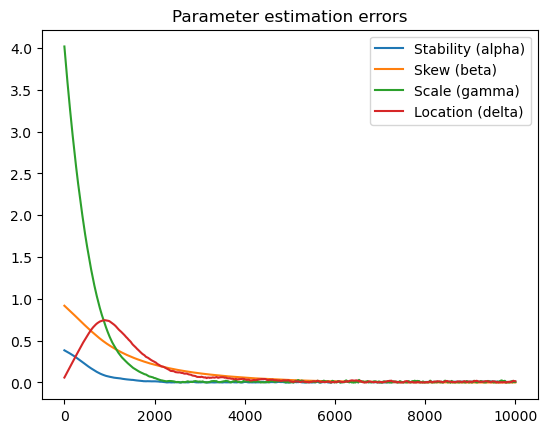

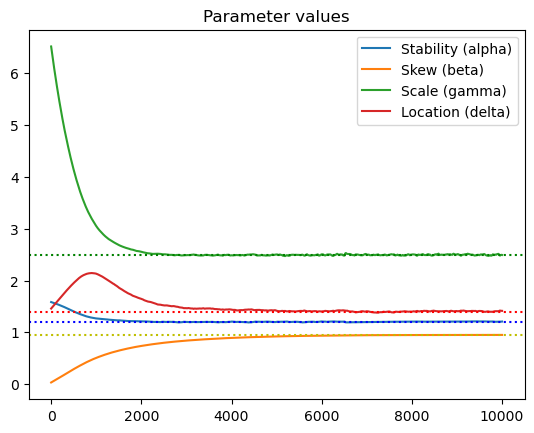

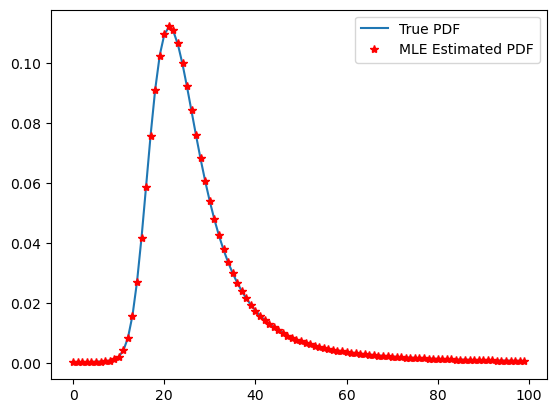

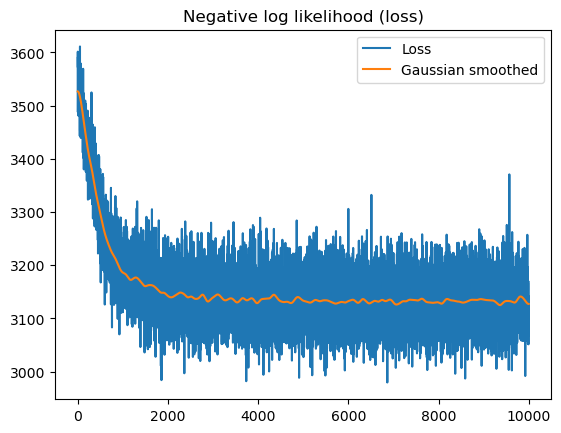

In [10]:
plot_stuff(param_values, per_param_errors, losses)

## Can fit alpha = beta = 1.0 well if we increase the number of integration gridpoints

In [12]:
torch.manual_seed(123)
# true = dist.Stable(1.8, 0.4, 2.5, 3.)
true_alpha = 1.0
true_beta = 1.0
true_scale = 2.5
true_loc = 0.0
true_dist = dist.Stable(true_alpha, true_beta, true_scale, true_loc)

module = MyModule()

num_steps = 10000
batch_size = 1000
integration_gridpoints = 10000

In [13]:
param_values, per_param_errors, losses = fit(true_dist, module, num_steps, batch_size, integration_gridpoints)

100%|██████████| 10000/10000 [15:00<00:00, 11.11it/s, iter_time=0.0874, loss=3.32e+3, param_error=0.0325]


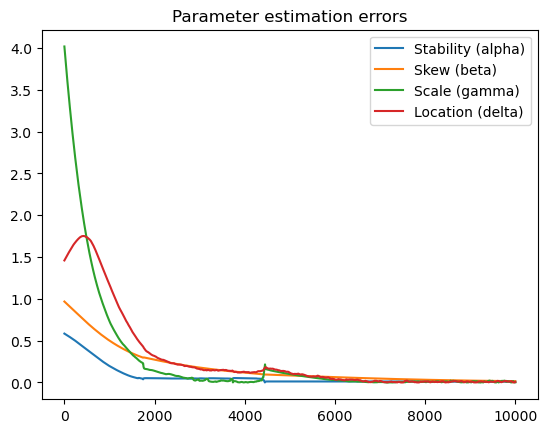

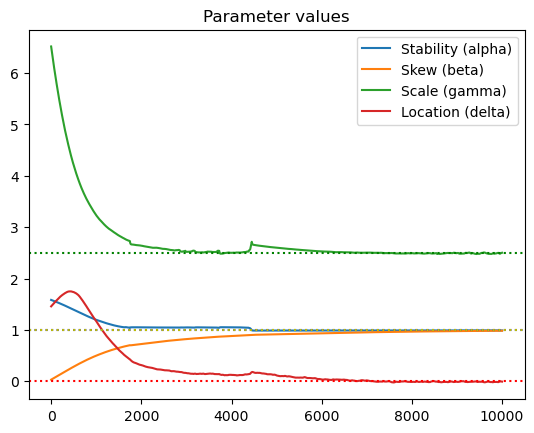

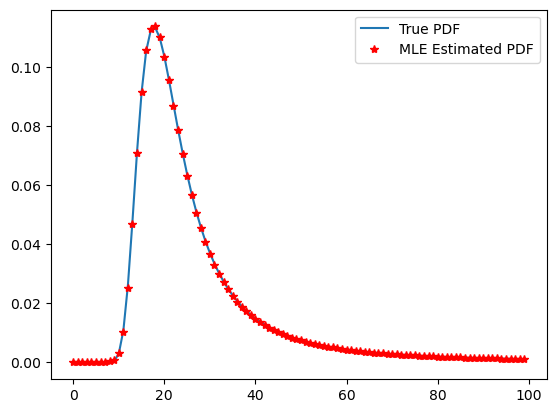

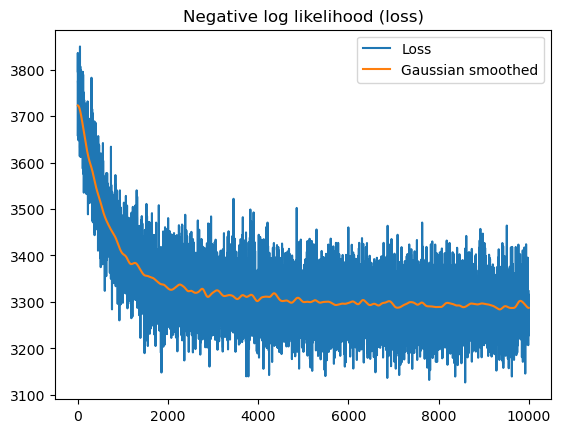

In [14]:
plot_stuff(param_values, per_param_errors, losses)

## For debugging

In [ ]:
# alpha = nn.Parameter(torch.tensor(1.1))
# beta = nn.Parameter(torch.tensor(0.5))
# stable_dist = StableWithLogProb(alpha, beta)
# x = stable_dist.sample((10,))
# log_prob = (-stable_dist.log_prob(x))
# print(log_prob)
# loss = log_prob.sum()
# loss.backward()